
# 📘 Feature_Importance_SHAP.ipynb
# Etapa 1: Imports

In [17]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
import sys
warnings.filterwarnings('ignore')

# Importa configurações do projeto

In [20]:
try:
    from src.config import BASE_DIR, DATA_PATH, FIGURES_PATH, MODELS_PATH
    print(f"✅ Configurações importadas do config.py")
    print(f"📁 Base do projeto: {BASE_DIR}")
except (ModuleNotFoundError, ImportError) as e:
    print(f"⚠️  Erro ao importar config.py: {e}")
    # Fallback: define caminhos manualmente
    BASE_DIR = Path.cwd()
    if BASE_DIR.name == 'notebooks':
        BASE_DIR = BASE_DIR.parent
    DATA_PATH = BASE_DIR / "data" / "BankChurners.csv"
    FIGURES_PATH = BASE_DIR / "reports" / "figures"
    MODELS_PATH = BASE_DIR / "models"
    FIGURES_PATH.mkdir(parents=True, exist_ok=True)
    print(f"📁 BASE_DIR definido como: {BASE_DIR}")

⚠️  Erro ao importar config.py: No module named 'src'
📁 BASE_DIR definido como: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros


# Etapa 2: Função de feature engineering (inline)

In [21]:
#Etapa 2: Função de feature engineering (inline)
def criar_variaveis_derivadas(df):
    """
    Cria variáveis derivadas para melhorar o poder preditivo do modelo
    """
    df = df.copy()
    
    # LTV Proxy (Lifetime Value aproximado)
    df['LTV_Proxy'] = df['Customer_Age'] * df['Total_Trans_Amt']
    
    # Razão de transações por relacionamento
    df['Trans_Per_Month'] = df['Total_Trans_Ct'] / df['Months_on_book']
    
    # Ticket médio
    df['Avg_Transaction_Value'] = df['Total_Trans_Amt'] / (df['Total_Trans_Ct'] + 1)
    
    # Utilização ajustada por limite
    df['Utilization_Efficiency'] = df['Avg_Utilization_Ratio'] * df['Credit_Limit']
    
    # Idade do cartão vs idade do cliente
    df['Card_Age_Ratio'] = df['Months_on_book'] / (df['Customer_Age'] + 1)
    
    return df


# Etapa 3: Leitura e preparação dos dados

In [22]:
print("\n" + "=" * 60)
print("PREPARAÇÃO DOS DADOS")
print("=" * 60)


PREPARAÇÃO DOS DADOS


# Define caminhos usando as variáveis do config.py

In [23]:
base_tratada_path = BASE_DIR / "data" / "base_tratada.csv"
bank_churners_path = DATA_PATH  # Já definido no config.py

# Verifica qual arquivo usar

In [24]:
use_raw = False
if base_tratada_path.exists():
    file_path = base_tratada_path
    print(f"✅ Usando base tratada: {file_path.name}")
elif bank_churners_path.exists():
    file_path = bank_churners_path
    use_raw = True
    print(f"✅ Usando base raw: {file_path.name}")
else:
    # Debug: mostra o que existe no diretório data/
    data_dir = BASE_DIR / "data"
    if data_dir.exists():
        print(f"\n📂 Conteúdo de {data_dir}:")
        for item in data_dir.iterdir():
            print(f"   - {item.name}")
    else:
        print(f"\n❌ Diretório não encontrado: {data_dir}")
    
    raise FileNotFoundError(
        f"\n❌ Nenhum arquivo de dados encontrado!\n"
        f"   Procurado em:\n"
        f"   - {base_tratada_path}\n"
        f"   - {bank_churners_path}\n"
        f"\n💡 Certifique-se de que um desses arquivos existe no diretório data/"
    )

print(f"📂 Lendo arquivo: {file_path.resolve()}")
df = pd.read_csv(file_path)
print(f"✅ Arquivo carregado! Shape inicial: {df.shape}")

✅ Usando base tratada: base_tratada.csv
📂 Lendo arquivo: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\data\base_tratada.csv
✅ Arquivo carregado! Shape inicial: (10127, 27)
✅ Arquivo carregado! Shape inicial: (10127, 27)


# Se for o arquivo raw, aplica feature engineering e prepara target

In [25]:
if use_raw:
    print("\n🔧 Aplicando feature engineering...")
    df = criar_variaveis_derivadas(df)
    
    # Remove colunas desnecessárias (últimas 2 são do Naive Bayes)
    df = df.iloc[:, :-2]
    
    # Cria variável target
    if 'Attrition_Flag' in df.columns:
        df['Attrition'] = (df['Attrition_Flag'] == 'Attrited Customer').astype(int)
        df = df.drop('Attrition_Flag', axis=1)
    
    print(f"✅ Feature engineering concluído! Nova shape: {df.shape}")

# Etapa 4: Seleção de variáveis

In [26]:
print("\n" + "=" * 60)
print("PREPARAÇÃO DO MODELO")
print("=" * 60)



PREPARAÇÃO DO MODELO


In [27]:
features = [
    'Customer_Age', 'Dependent_count', 'Credit_Limit', 
    'Total_Trans_Amt', 'Total_Trans_Ct',
    'Avg_Utilization_Ratio', 'Total_Ct_Chng_Q4_Q1', 'Total_Amt_Chng_Q4_Q1',
    'LTV_Proxy', 'Trans_Per_Month', 'Avg_Transaction_Value'
]

# Filtra apenas features que existem no dataframe

In [28]:
available_features = [f for f in features if f in df.columns]
print(f"📊 Features disponíveis: {len(available_features)}/{len(features)}")
print(f"   {', '.join(available_features)}")

X = df[available_features]
y = df['Attrition']

print(f"\n📈 Distribuição do target:")
print(f"   Não-Churn: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"   Churn: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")


📊 Features disponíveis: 8/11
   Customer_Age, Dependent_count, Credit_Limit, Total_Trans_Amt, Total_Trans_Ct, Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Amt_Chng_Q4_Q1

📈 Distribuição do target:
   Não-Churn: 8500 (83.9%)
   Churn: 1627 (16.1%)


# Split estratificado

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
print(f"\n✅ Split realizado:")
print(f"   Treino: {X_train.shape[0]} amostras")
print(f"   Teste: {X_test.shape[0]} amostras")



✅ Split realizado:
   Treino: 7088 amostras
   Teste: 3039 amostras


# Etapa 5: Treinamento do modelo XGBoost

In [30]:
print("\n" + "=" * 60)
print("TREINAMENTO DO MODELO")
print("=" * 60)

# Configuração explícita para compatibilidade com SHAP
model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    base_score=0.5  # Define explicitamente como float para compatibilidade com SHAP
)

model.fit(X_train, y_train)
print("✅ Modelo XGBoost treinado com sucesso!")


TREINAMENTO DO MODELO
✅ Modelo XGBoost treinado com sucesso!
✅ Modelo XGBoost treinado com sucesso!


# Avaliação básica

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 Performance do modelo:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   AUC-ROC: {auc:.4f}")


📊 Performance do modelo:
   Accuracy: 0.9618
   AUC-ROC: 0.9886


✅ Biblioteca SHAP carregada com sucesso!
🔍 Calculando valores SHAP...
✅ Valores SHAP calculados!

📊 Salvando gráficos em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\figures

📊 Gerando Summary Plot...
✅ Valores SHAP calculados!

📊 Salvando gráficos em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\figures

📊 Gerando Summary Plot...


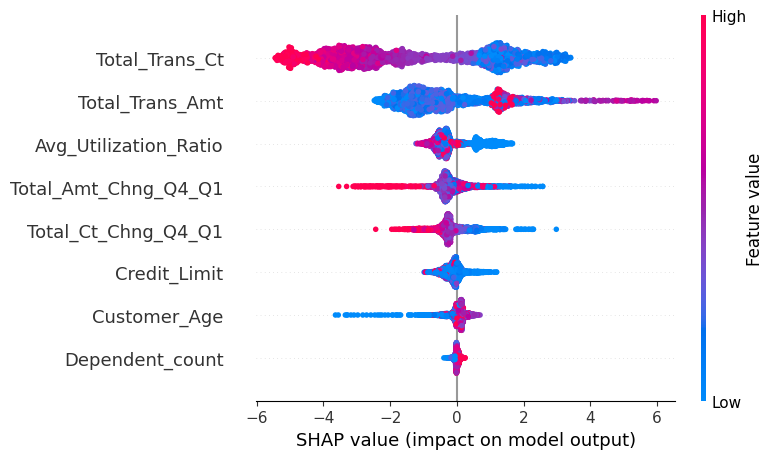

   ✅ Salvo em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\figures\shap_summary_plot.png

📊 Gerando Bar Plot...


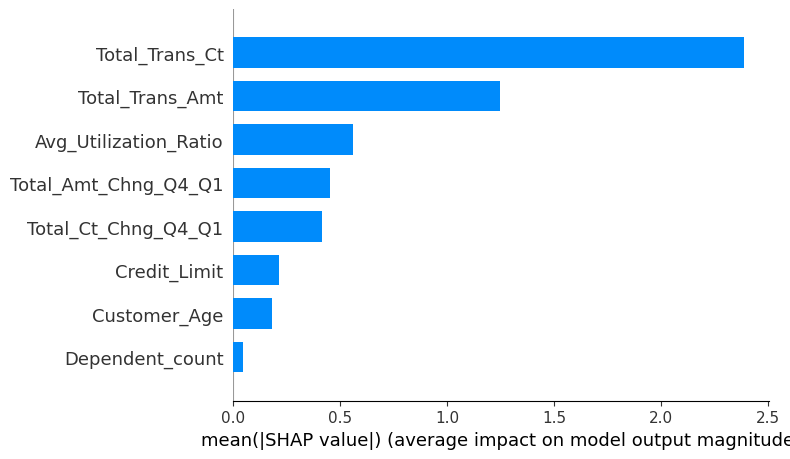

   ✅ Salvo em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\figures\shap_bar_plot.png

📊 Gerando Dependence Plot para 'Total_Trans_Ct'...


<Figure size 1000x600 with 0 Axes>

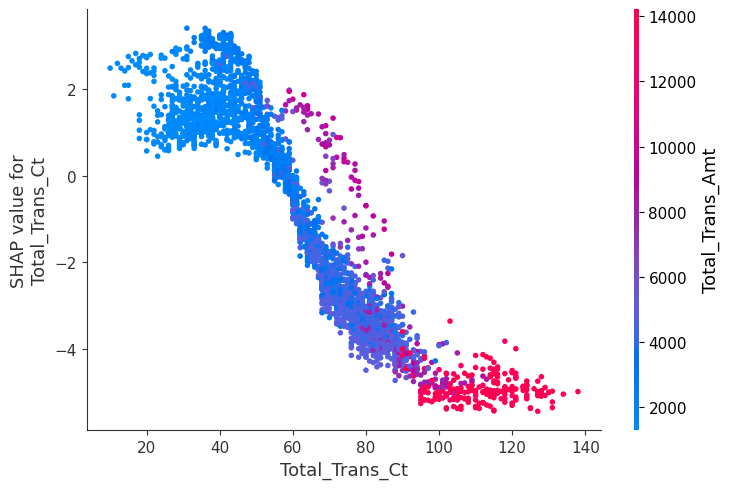

   ✅ Salvo em: c:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\reports\figures\shap_dependence_Total_Trans_Ct.png

TOP 5 FEATURES MAIS IMPORTANTES
Total_Trans_Ct                 | 2.3874
Total_Trans_Amt                | 1.2458
Avg_Utilization_Ratio          | 0.5579
Total_Amt_Chng_Q4_Q1           | 0.4527
Total_Ct_Chng_Q4_Q1            | 0.4146

INSIGHTS E RECOMENDAÇÕES

✅ Análise concluída com sucesso!

📌 PRINCIPAIS INSIGHTS:
• As variáveis relacionadas a transações (Total_Trans_Ct, Total_Trans_Amt) 
  têm alto poder preditivo para churn
• Mudanças no comportamento transacional (Q4 vs Q1) são indicadores importantes
• Variáveis derivadas (LTV_Proxy, Trans_Per_Month) agregam valor ao modelo

💡 RECOMENDAÇÕES PARA RETENÇÃO:
1. Monitorar clientes com queda abrupta no número de transações
2. Criar campanhas direcionadas para clientes com baixa atividade transacional
3. Priorizar clientes com alto LTV_Proxy em programas de fidelidade
4. Investigar mudanças s

In [32]:
try:
    import shap
    print("✅ Biblioteca SHAP carregada com sucesso!")
    
    print("🔍 Calculando valores SHAP...")
    
    # Limpa dados de teste
    X_test_clean = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Tenta usar TreeExplainer com tratamento de erro
    try:
        # Usa TreeExplainer específico para XGBoost
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_clean)
        
        # Para classificação binária, pega apenas os valores da classe positiva
        if isinstance(shap_values, list):
            shap_values_display = shap_values[1]  # Classe 1 (Churn)
        else:
            shap_values_display = shap_values
            
    except (ValueError, AttributeError) as e:
        print(f"⚠️  TreeExplainer falhou: {str(e)[:100]}")
        print("   Tentando método alternativo com predict...")
        
        # Método alternativo: usa modelo como função de predição
        explainer = shap.Explainer(model.predict_proba, X_train)
        shap_values_obj = explainer(X_test_clean)
        shap_values_display = shap_values_obj.values[:, 1]  # Classe positiva
    
    print("✅ Valores SHAP calculados!")
    
    # Usa FIGURES_PATH do config.py
    print(f"\n📊 Salvando gráficos em: {FIGURES_PATH}")
    
    # Visualização 1: Summary Plot
    print("\n📊 Gerando Summary Plot...")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_display, X_test_clean, show=False)
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / "shap_summary_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Salvo em: {FIGURES_PATH / 'shap_summary_plot.png'}")
    
    # Visualização 2: Bar Plot
    print("\n📊 Gerando Bar Plot...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_display, X_test_clean, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / "shap_bar_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Salvo em: {FIGURES_PATH / 'shap_bar_plot.png'}")
    
    # Visualização 3: Dependence Plot para feature mais importante
    most_important_feature = X_test_clean.columns[
        np.abs(shap_values_display).mean(0).argmax()
    ]
    print(f"\n📊 Gerando Dependence Plot para '{most_important_feature}'...")
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        most_important_feature, 
        shap_values_display, 
        X_test_clean, 
        show=False
    )
    plt.tight_layout()
    plt.savefig(
        FIGURES_PATH / f"shap_dependence_{most_important_feature}.png", 
        dpi=300, 
        bbox_inches='tight'
    )
    plt.show()
    print(f"   ✅ Salvo em: {FIGURES_PATH / f'shap_dependence_{most_important_feature}.png'}")
    
    # Feature importance summary
    print("\n" + "=" * 60)
    print("TOP 5 FEATURES MAIS IMPORTANTES")
    print("=" * 60)
    
    feature_importance = pd.DataFrame({
        'feature': X_test_clean.columns,
        'importance': np.abs(shap_values_display).mean(0)
    }).sort_values('importance', ascending=False)
    
    for idx, row in feature_importance.head(5).iterrows():
        print(f"{row['feature']:30s} | {row['importance']:.4f}")
    
except ModuleNotFoundError:
    print("\n❌ A biblioteca SHAP não está instalada!")
    print("   Execute: pip install shap")
    print("\n💡 Continuando com feature importance do XGBoost...")
    
    # Feature importance alternativa usando XGBoost nativo
    importance_df = pd.DataFrame({
        'feature': available_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (XGBoost)')
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / "xgb_feature_importance.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Feature Importance (XGBoost):")
    print(importance_df.to_string(index=False))

# Conclusão
print("\n" + "=" * 60)
print("INSIGHTS E RECOMENDAÇÕES")
print("=" * 60)
print("""
✅ Análise concluída com sucesso!

📌 PRINCIPAIS INSIGHTS:
• As variáveis relacionadas a transações (Total_Trans_Ct, Total_Trans_Amt) 
  têm alto poder preditivo para churn
• Mudanças no comportamento transacional (Q4 vs Q1) são indicadores importantes
• Variáveis derivadas (LTV_Proxy, Trans_Per_Month) agregam valor ao modelo

💡 RECOMENDAÇÕES PARA RETENÇÃO:
1. Monitorar clientes com queda abrupta no número de transações
2. Criar campanhas direcionadas para clientes com baixa atividade transacional
3. Priorizar clientes com alto LTV_Proxy em programas de fidelidade
4. Investigar mudanças sazonais no comportamento (Q4 vs Q1)
""")